# Uncertainty-based sampling

In the previous tutorial, you learned how to implement a closed-loop experiment with random and grid sampling. However, these strategies don't use any information about what the model knows or doesn't know.

**Uncertainty-based sampling** is a more intelligent strategy that:
- Samples experimental conditions where the model is most uncertain
- Maximizes information gain from each new observation
- Efficiently explores the experimental space

This approach is grounded in **Information Theory**:
- **High uncertainty** = high entropy = low information
- **Sampling high-uncertainty regions** = maximum information gain
- **Reducing uncertainty** = reducing entropy = learning

In this tutorial, you will learn to:
- Use Gaussian Processes that naturally provide uncertainty estimates
- Visualize uncertainty across the experimental space
- Implement uncertainty-based sampling with AutoRA
- Observe how uncertainty decreases cycle-by-cycle
- Compare uncertainty sampling to random sampling

Let's get started!

## Library imports

In [ ]:
import sys, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from typing import List

# Set the path to the project folder
target_folder = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Adjust path as needed
if target_folder not in sys.path:
    sys.path.append(target_folder)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.base import BaseEstimator

from autora.experimentalist.random import random_pool
from autora.variable import Variable, VariableCollection

from resources.synthetic import twoafc

## Setting up the synthetic experiment

In [ ]:
# Basic experiment parameters
n_units = 10  # Number of synthetic participants
noise_level = 0.  # noise added to the experiment runners observations

# Sample parameters for each synthetic participant
parameters = np.random.normal(1, 1, (n_units, 2))
parameters = (parameters - parameters.min()) / (parameters.max() - parameters.min())
parameters = parameters * 2

# Create the experiment
experiment = twoafc(parameters, noise_level=noise_level)

print(f"Created experiment with {n_units} synthetic participants")
print(f"Noise level: {noise_level}")

## Understanding Gaussian Processes

A **Gaussian Process (GP)** is a probabilistic model that naturally provides uncertainty estimates:
- **Mean prediction**: The model's best guess for the response time
- **Variance/uncertainty**: How confident the model is in its prediction

Key properties:
- **Near observed data**: Low uncertainty (the model has seen similar conditions)
- **Far from observed data**: High uncertainty (the model hasn't explored this region)
- **More data** → reduced uncertainty in those regions

This makes GPs perfect for uncertainty-based sampling!

In [ ]:
# Define a Gaussian Process model
# The kernel controls how the model generalizes:
# - RBF kernel: assumes smooth functions
# - ConstantKernel: scales the output

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2))
theorist = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2, alpha=1e-6)

print("Gaussian Process model initialized")
print(f"Kernel: {kernel}")

## Helper function for visualization

Let's create a helper function to visualize predictions and uncertainty for a single participant:

In [ ]:
def plot_predictions_and_uncertainty(experiment, model, participant_id, conditions_sampled=None, title=""):
    """
    Plot model predictions and uncertainty for a specific participant.
    
    Args:
        experiment: The experiment runner
        model: Trained Gaussian Process model
        participant_id: Which participant to visualize
        conditions_sampled: Array of sampled conditions to overlay (optional)
        title: Title prefix for the plots
    """
    # Create a grid of conditions to evaluate
    ratio = np.linspace(0, 1, 50)
    scatteredness = np.linspace(0, 1, 50)
    ratio_mesh, scatteredness_mesh = np.meshgrid(ratio, scatteredness)
    
    # Prepare input for the model: [participant_id, ratio, scatteredness]
    grid_conditions = np.column_stack([
        # np.full(ratio_mesh.ravel().shape, participant_id),
        ratio_mesh.ravel(),
        scatteredness_mesh.ravel()
    ])
    
    # Get predictions and uncertainty (std) from the GP
    predictions, std = model.predict(grid_conditions, return_std=True)
    predictions = predictions.reshape(ratio_mesh.shape)
    uncertainty = std.reshape(ratio_mesh.shape)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(18, 5))
    
    # Plot 1: 3D surface of predictions
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(ratio_mesh, scatteredness_mesh, predictions, cmap=cm.viridis, alpha=0.8)
    ax1.set_xlabel('Ratio')
    ax1.set_ylabel('Scatteredness')
    ax1.set_zlabel('Response Time')
    ax1.set_title(f'{title}\nPredictions (Participant {participant_id})')
    
    # Plot 2: Uncertainty heatmap
    ax2 = fig.add_subplot(132)
    im = ax2.contourf(ratio_mesh, scatteredness_mesh, uncertainty, levels=20, cmap='YlOrRd')
    ax2.set_xlabel('Ratio')
    ax2.set_ylabel('Scatteredness')
    ax2.set_title(f'{title}\nUncertainty (Std Dev)')
    plt.colorbar(im, ax=ax2, label='Uncertainty')
    
    # Overlay sampled conditions if provided
    if conditions_sampled is not None:
        # Filter conditions for this participant
        participant_conditions = conditions_sampled[conditions_sampled[:, 0] == participant_id]
        if len(participant_conditions) > 0:
            ax2.scatter(participant_conditions[:, 1], participant_conditions[:, 2], 
                       c='blue', s=30, marker='x', linewidths=2, label='Sampled', zorder=5)
            ax2.legend()
    
    # Plot 3: Predictions with uncertainty bands (slice at scatteredness=0.5)
    ax3 = fig.add_subplot(133)
    mid_idx = len(scatteredness) // 2
    pred_slice = predictions[mid_idx, :]
    unc_slice = uncertainty[mid_idx, :]
    
    ax3.plot(ratio, pred_slice, 'b-', linewidth=2, label='Mean prediction')
    ax3.fill_between(ratio, pred_slice - 2*unc_slice, pred_slice + 2*unc_slice, 
                     alpha=0.3, color='blue', label='95% confidence')
    ax3.set_xlabel('Ratio')
    ax3.set_ylabel('Response Time')
    ax3.set_title(f'{title}\nSlice at Scatteredness=0.5')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print uncertainty statistics
    print(f"Mean uncertainty: {uncertainty.mean():.4f}")
    print(f"Max uncertainty: {uncertainty.max():.4f}")
    print(f"Min uncertainty: {uncertainty.min():.4f}")

## Cycle 0: Initial random sampling

Let's start with an initial set of random conditions and see what the uncertainty looks like:

In [ ]:
from autora.experimentalist.random import random_pool

# Generate initial random conditions
n_samples_per_cycle = 5
conditions = random_pool(experiment.variables, n_samples_per_cycle).to_numpy()

print(f"Generated {len(conditions)} initial random conditions")
print(f"Condition shape: {conditions.shape}")

In [ ]:
# Run the experiment and collect data
experiment_data = experiment.run(conditions, random_state=42).to_numpy()

# Extract features (X) and target (y)
n_dv = len(experiment.variables.dependent_variables)
X = experiment_data[:, 1:-n_dv]
y = experiment_data[:, -n_dv:]

# Fit the Gaussian Process
theorist.fit(X, y)

print(f"\nCycle 0 completed: {len(X)} total samples")
print(f"Model fitted on data with shape X={X.shape}, y={y.shape}")
print(conditions)

### Visualize Cycle 0 results

Let's visualize the predictions and uncertainty after the initial random sampling. Notice:
- **High uncertainty** in regions far from sampled points
- **Lower uncertainty** near sampled points
- The model is **uncertain about most of the space** because we've only sampled 50 points

In [ ]:
plot_predictions_and_uncertainty(
    experiment=experiment,
    model=theorist,
    participant_id=0,
    conditions_sampled=conditions,
    title="Cycle 0: Initial Random Sampling"
)

## Uncertainty sampler

In order to make use of the uncertainty estimate of the Gaussian Process, we have to implement an experimentalist which samples the next conditions in the areas of highest uncertainty.

Follow the next steps in order to implement your first own experimentalist.

In [ ]:
def uncertainty_sample(conditions: VariableCollection, model, num_samples=1, pool_size=10000, random_state=None):
    """
    Sample experimental condition(s) with highest GP uncertainty.
    
    Samples one point at a time based on maximum standard deviation from the GP.
    For multiple samples, this function should be called iteratively with model
    refitting between calls to ensure diversity.
    
    Args:
        conditions: AutoRA VariableCollection describing experimental space
        model: Trained GaussianProcessRegressor with predict(X, return_std=True)
        num_samples: Number of samples to return (default=1, keeping at 1 is recommended)
        pool_size: Size of random candidate pool to evaluate (default=10000)
        random_state: Random seed for reproducibility
        
    Returns:
        DataFrame with selected experimental condition(s)
    """
    # Step 1: Generate candidate pool
    candidate_pool = random_pool(conditions, pool_size, random_state=random_state).to_numpy()
    
    # Step 2: Get uncertainty estimates from GP
    _, std = model.predict(candidate_pool, return_std=True)
    
    # Step 3: Select point(s) with highest uncertainty
    if num_samples == 1:
        # Most common case: select single highest uncertainty point
        max_idx = np.argmax(std)
        selected = candidate_pool[max_idx:max_idx+1]  # Keep 2D shape
    else:
        # For multiple samples: select top-k by uncertainty
        # Note: This may cluster points! Better to call this function iteratively.
        top_indices = np.argsort(std)[-num_samples:][::-1]
        selected = candidate_pool[top_indices]
    
    # Return as DataFrame
    ivs = conditions.independent_variables
    column_names = [iv.name for iv in ivs]
    return pd.DataFrame(selected, columns=column_names)

## Iteratively refining the model with uncertainty-based sampling

### Cycle 1

Now let's use **uncertainty-based sampling** to select the next batch of conditions. The AutoRA uncertainty sampler will:
1. Generate a pool of candidate conditions
2. Use the GP to predict uncertainty for each candidate
3. Select the conditions with the **highest uncertainty**

This should focus sampling on regions where the model is most uncertain!

In [ ]:
# Use uncertainty sampling to select new conditions
# The sampler needs a model that has a predict method returning mean and std
new_conditions = uncertainty_sample(
    conditions=experiment.variables,
    model=theorist,
).to_numpy()

print(f"Sampled {len(new_conditions)} new conditions based on uncertainty:")
print(f"{new_conditions[:5]}")

In [ ]:
# Run experiment on new conditions
new_data = experiment.run(new_conditions, random_state=43).to_numpy()

# Combine with previous data
experiment_data = np.vstack([experiment_data, new_data])
conditions = np.vstack([conditions, new_conditions])

# Extract features and target
X = experiment_data[:, 1:-n_dv]
y = experiment_data[:, -n_dv:].ravel()

# Refit the Gaussian Process with all data
theorist.fit(X, y)

print(f"\nCycle 1 completed: {len(X)} total samples")
print(f"Model refitted on accumulated data")

**Visualize Cycle 1 results**

Compare to Cycle 0. You should see:
- **Reduced uncertainty** in regions that were previously uncertain
- Uncertainty-based sampling **targeted high-uncertainty regions**
- More **efficient exploration** compared to random sampling

In [ ]:
plot_predictions_and_uncertainty(
    experiment=experiment,
    model=theorist,
    participant_id=0,
    conditions_sampled=conditions,
    title="Cycle 1: After Uncertainty Sampling"
)

### Cycle 2

Let's continue for another cycle to see how uncertainty continues to decrease:

In [ ]:
# Uncertainty sampling for cycle 2
new_conditions = uncertainty_sample(
    conditions=experiment.variables,
    model=theorist,
).to_numpy()

# Run experiment
new_data = experiment.run(new_conditions, random_state=44).to_numpy()

# Accumulate data
experiment_data = np.vstack([experiment_data, new_data])
conditions = np.vstack([conditions, new_conditions])

# Refit model
X = experiment_data[:, 1:-n_dv]
y = experiment_data[:, -n_dv:].ravel()
theorist.fit(X, y)

print(f"New condition: {new_conditions[:5]}")
print(f"Cycle 2 completed: {len(X)} total samples")

**Visualize Cycle 2 results**

In [ ]:
plot_predictions_and_uncertainty(
    experiment=experiment,
    model=theorist,
    participant_id=0,
    conditions_sampled=conditions,
    title="Cycle 2: Further Refinement"
)

### Cycle 3

One more cycle to see how low we can get the uncertainty:

In [ ]:
# Uncertainty sampling for cycle 3
new_conditions = uncertainty_sample(
    conditions=experiment.variables,
    model=theorist,
).to_numpy()

# Run experiment
new_data = experiment.run(new_conditions, random_state=45).to_numpy()

# Accumulate data
experiment_data = np.vstack([experiment_data, new_data])
conditions = np.vstack([conditions, new_conditions])

# Refit model
X = experiment_data[:, 1:-n_dv]
y = experiment_data[:, -n_dv:].ravel()
theorist.fit(X, y)

print(f"New condition: {new_conditions[:5]}")
print(f"Cycle 3 completed: {len(X)} total samples")

### Visualize Cycle 3 results

After 4 cycles (200 samples), the uncertainty should be substantially reduced across most of the experimental space.

In [ ]:
plot_predictions_and_uncertainty(
    experiment=experiment,
    model=theorist,
    participant_id=0,
    conditions_sampled=conditions,
    title="Cycle 3: Near-Complete Coverage"
)

## Comparison: Uncertainty vs Random Sampling

Now let's compare uncertainty-based sampling to random sampling with the same number of samples. This will show us whether uncertainty sampling is truly more efficient.

In [ ]:
# Create a new GP model for random sampling
kernel_random = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2))
theorist_random = GaussianProcessRegressor(kernel=kernel_random, n_restarts_optimizer=2, alpha=1e-6)

# Generate all random conditions at once (same total number as uncertainty sampling)
total_samples = len(conditions)
conditions_random = random_pool(experiment.variables, total_samples).to_numpy()

# Run experiment on all random conditions
experiment_data_random = experiment.run(conditions_random, random_state=100).to_numpy()

# Fit the model
X_random = experiment_data_random[:, 1:-n_dv]
y_random = experiment_data_random[:, -n_dv:].ravel()
theorist_random.fit(X_random, y_random)

print(f"Random sampling completed with {len(X_random)} samples")
print(f"Same as uncertainty sampling: {len(X)} samples")

### Visualize comparison

Let's create a side-by-side comparison of uncertainty maps:

In [ ]:
def compare_uncertainty_maps(experiment, model_unc, model_rand, participant_id, cond_unc, cond_rand):
    """
    Side-by-side comparison of uncertainty maps.
    """
    # Create grid
    ratio = np.linspace(0, 1, 50)
    scatteredness = np.linspace(0, 1, 50)
    ratio_mesh, scatteredness_mesh = np.meshgrid(ratio, scatteredness)
    
    grid_conditions = np.column_stack([
        # np.full(ratio_mesh.ravel().shape, participant_id),
        ratio_mesh.ravel(),
        scatteredness_mesh.ravel()
    ])
    
    # Get predictions and uncertainty from both models
    _, std_unc = model_unc.predict(grid_conditions, return_std=True)
    _, std_rand = model_rand.predict(grid_conditions, return_std=True)
    
    uncertainty_unc = std_unc.reshape(ratio_mesh.shape)
    uncertainty_rand = std_rand.reshape(ratio_mesh.shape)
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Use same color scale for fair comparison
    vmax = max(uncertainty_unc.max(), uncertainty_rand.max())
    
    # Uncertainty sampling
    im1 = ax1.contourf(ratio_mesh, scatteredness_mesh, uncertainty_unc, levels=20, cmap='YlOrRd', vmax=vmax)
    participant_cond_unc = cond_unc[cond_unc[:, 0] == participant_id]
    if len(participant_cond_unc) > 0:
        ax1.scatter(participant_cond_unc[:, 1], participant_cond_unc[:, 2], 
                   c='blue', s=20, marker='x', linewidths=1.5, alpha=0.6)
    ax1.set_xlabel('Ratio')
    ax1.set_ylabel('Scatteredness')
    ax1.set_title(f'Uncertainty Sampling\n(Participant {participant_id})')
    plt.colorbar(im1, ax=ax1, label='Uncertainty')
    
    # Random sampling
    im2 = ax2.contourf(ratio_mesh, scatteredness_mesh, uncertainty_rand, levels=20, cmap='YlOrRd', vmax=vmax)
    participant_cond_rand = cond_rand[cond_rand[:, 0] == participant_id]
    if len(participant_cond_rand) > 0:
        ax2.scatter(participant_cond_rand[:, 1], participant_cond_rand[:, 2], 
                   c='blue', s=20, marker='x', linewidths=1.5, alpha=0.6)
    ax2.set_xlabel('Ratio')
    ax2.set_ylabel('Scatteredness')
    ax2.set_title(f'Random Sampling\n(Participant {participant_id})')
    plt.colorbar(im2, ax=ax2, label='Uncertainty')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nUncertainty Statistics:")
    print(f"Uncertainty Sampling - Mean: {uncertainty_unc.mean():.4f}, Max: {uncertainty_unc.max():.4f}")
    print(f"Random Sampling      - Mean: {uncertainty_rand.mean():.4f}, Max: {uncertainty_rand.max():.4f}")
    print(f"\nReduction in mean uncertainty: {(uncertainty_rand.mean() - uncertainty_unc.mean()) / uncertainty_rand.mean() * 100:.1f}%")

compare_uncertainty_maps(
    experiment=experiment,
    model_unc=theorist,
    model_rand=theorist_random,
    participant_id=0,
    cond_unc=conditions,
    cond_rand=conditions_random
)

### Quantitative comparison

Let's also compare the models on held-out test data to see which strategy learned better:

In [ ]:
# Generate test conditions
test_conditions = random_pool(experiment.variables, 1000).to_numpy()
test_data = experiment.run(test_conditions, random_state=999, noise_level_run=0.).to_numpy()

X_test = test_data[:, 1:-n_dv]
y_test = test_data[:, -n_dv:]

# Predictions from both models
y_pred_unc = theorist.predict(X_test)
y_pred_rand = theorist_random.predict(X_test)

# Calculate MSE
mse_unc = np.mean((y_test - y_pred_unc)**2)
mse_rand = np.mean((y_test - y_pred_rand)**2)

# Calculate R²
from sklearn.metrics import r2_score
r2_unc = r2_score(y_test, y_pred_unc)
r2_rand = r2_score(y_test, y_pred_rand)

print("Test Set Performance (500 samples):")
print("=" * 50)
print(f"Uncertainty Sampling - MSE: {mse_unc:.6f}, R²: {r2_unc:.4f}")
print(f"Random Sampling      - MSE: {mse_rand:.6f}, R²: {r2_rand:.4f}")
print("=" * 50)
print(f"Improvement in MSE: {(mse_rand - mse_unc) / mse_rand * 100:.1f}%")
print(f"Improvement in R²: {(r2_unc - r2_rand) / (1 - r2_rand) * 100:.1f}%")

How does the quantitative comparison look like? 

Is the uncertainty sampler any better?

**Challenge:**
Find use-cases where it's actually outperforming random sampling by a good margin!

Implement your own closed-loop as you know it from the previous AutoRA tutorial.

Set up the 2AFC experiment with a different noise level and sample one experimental condition at a time with the uncertainty sampler and the random sampler!

In [ ]:
# ADD YOUR CODE HERE

# WITHOUT NOISE

from autora.experimentalist.grid import grid_pool

n_units = 10
n_cycles = 30
noise_level = 0.

parameters = np.random.normal(0, 1, (n_units, 2))
parameters = (parameters - parameters.min()) / (parameters.max() - parameters.min()) + 1e-6
parameters *= 2

# initial data
experiment = twoafc(parameters, noise_level=noise_level)
experiment_discrete = twoafc(parameters, discrete_iv=True, resolution=3)
conditions_uncertainty = grid_pool(experiment_discrete.variables) + 1e-6
conditions_random = grid_pool(experiment_discrete.variables) + 1e-6

# test data
test_conditions = random_pool(experiment.variables, num_samples=1000)
test_data = experiment.run(test_conditions, noise_level_run=0).to_numpy()

def init_theorists():    
    kernel_uncertainty = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2))
    theorist_uncertainty = GaussianProcessRegressor(kernel=kernel_uncertainty, n_restarts_optimizer=2, alpha=1e-6)

    kernel_random = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2))
    theorist_random = GaussianProcessRegressor(kernel=kernel_random, n_restarts_optimizer=2, alpha=1e-6)
    
    return theorist_uncertainty, theorist_random

mse_uncertainty_all = np.zeros(n_cycles)
mse_random_all = np.zeros(n_cycles)

for cycle in range(n_cycles):
    
    theorist_uncertainty, theorist_random = init_theorists()

    # collect data from experiment
    experiment_data_uncertainty = experiment.run(conditions_uncertainty).to_numpy()
    experiment_data_random = experiment.run(conditions_random).to_numpy()
    
    # fit your model
    theorist_uncertainty.fit(experiment_data_uncertainty[:, 1:-1], experiment_data_uncertainty[:, -1:])
    theorist_random.fit(experiment_data_random[:, 1:-1], experiment_data_random[:, -1:])
    
    # get test predictions
    pred_uncertainty = theorist_uncertainty.predict(test_data[:, 1:-1])
    mse_uncertainty = np.mean((test_data[:, -1:]-pred_uncertainty)**2)
    mse_uncertainty_all[cycle] += mse_uncertainty
    
    pred_random = theorist_random.predict(test_data[:, 1:-1])
    mse_random = np.mean((test_data[:, -1:]-pred_random)**2)
    mse_random_all[cycle] += mse_random
    
    # get new conditions
    new_conditions_uncertainty = uncertainty_sample(experiment.variables, theorist_uncertainty)
    conditions_uncertainty = np.concatenate((conditions_uncertainty, new_conditions_uncertainty))
    
    new_conditions_random = random_pool(experiment.variables, num_samples=1)
    conditions_random = np.concatenate((conditions_random, new_conditions_random))
    
    # print results
    print(f"Cycle {cycle+1}/{n_cycles}: Uncertainty MSE = {np.round(mse_uncertainty, 8)}; Random MSE = {np.round(mse_random, 8)}")
    
plt.plot(mse_random_all, label='random')
plt.plot(mse_uncertainty_all, label='uncertainty')
plt.legend()
plt.show()

In [ ]:
# ADD YOUR CODE HERE

# WITH LITTLE NOISE

from autora.experimentalist.grid import grid_pool

n_units = 10
n_cycles = 30
noise_level = 0.1

parameters = np.random.normal(0, 1, (n_units, 2))
parameters = (parameters - parameters.min()) / (parameters.max() - parameters.min()) + 1e-6
parameters *= 2

# initial data
experiment = twoafc(parameters, noise_level=noise_level)
experiment_discrete = twoafc(parameters, discrete_iv=True, resolution=3)
conditions_uncertainty = grid_pool(experiment_discrete.variables) + 1e-6
conditions_random = grid_pool(experiment_discrete.variables) + 1e-6

# test data
test_conditions = random_pool(experiment.variables, num_samples=1000)
test_data = experiment.run(test_conditions, noise_level_run=0).to_numpy()

def init_theorists():    
    kernel_uncertainty = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2))
    theorist_uncertainty = GaussianProcessRegressor(kernel=kernel_uncertainty, n_restarts_optimizer=2, alpha=1e-6)

    kernel_random = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2))
    theorist_random = GaussianProcessRegressor(kernel=kernel_random, n_restarts_optimizer=2, alpha=1e-6)
    
    return theorist_uncertainty, theorist_random

mse_uncertainty_all = np.zeros(n_cycles)
mse_random_all = np.zeros(n_cycles)

for cycle in range(n_cycles):
    
    theorist_uncertainty, theorist_random = init_theorists()

    # collect data from experiment
    experiment_data_uncertainty = experiment.run(conditions_uncertainty).to_numpy()
    experiment_data_random = experiment.run(conditions_random).to_numpy()
    
    # fit your model
    theorist_uncertainty.fit(experiment_data_uncertainty[:, 1:-1], experiment_data_uncertainty[:, -1:])
    theorist_random.fit(experiment_data_random[:, 1:-1], experiment_data_random[:, -1:])
    
    # get test predictions
    pred_uncertainty = theorist_uncertainty.predict(test_data[:, 1:-1])
    mse_uncertainty = np.mean((test_data[:, -1:]-pred_uncertainty)**2)
    mse_uncertainty_all[cycle] += mse_uncertainty
    pred_random = theorist_random.predict(test_data[:, 1:-1])
    mse_random = np.mean((test_data[:, -1:]-pred_random)**2)
    mse_random_all[cycle] += mse_random
    
    # get new conditions
    new_conditions_uncertainty = uncertainty_sample(experiment.variables, theorist_uncertainty)
    conditions_uncertainty = np.concatenate((conditions_uncertainty, new_conditions_uncertainty))
    new_conditions_random = random_pool(experiment.variables, num_samples=1)
    conditions_random = np.concatenate((conditions_random, new_conditions_random))
    
    # print results
    print(f"Cycle {cycle+1}/{n_cycles}: Uncertainty MSE = {np.round(mse_uncertainty, 8)}; Random MSE = {np.round(mse_random, 8)}")
    
plt.plot(mse_random_all, label='random')
plt.plot(mse_uncertainty_all, label='uncertainty')
plt.legend()
plt.show()

In [ ]:
# ADD YOUR CODE HERE

# WITH MORE NOISE

from autora.experimentalist.grid import grid_pool

n_units = 10
n_cycles = 30
noise_level = 0.3

parameters = np.random.normal(0, 1, (n_units, 2))
parameters = (parameters - parameters.min()) / (parameters.max() - parameters.min()) + 1e-6
parameters *= 2

# initial data
experiment = twoafc(parameters, noise_level=noise_level)
experiment_discrete = twoafc(parameters, discrete_iv=True, resolution=3)
conditions_uncertainty = grid_pool(experiment_discrete.variables) + 1e-6
conditions_random = grid_pool(experiment_discrete.variables) + 1e-6

# test data
test_conditions = random_pool(experiment.variables, num_samples=1000)
test_data = experiment.run(test_conditions, noise_level_run=0).to_numpy()

def init_theorists():    
    kernel_uncertainty = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2))
    theorist_uncertainty = GaussianProcessRegressor(kernel=kernel_uncertainty, n_restarts_optimizer=2, alpha=1e-6)

    kernel_random = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2))
    theorist_random = GaussianProcessRegressor(kernel=kernel_random, n_restarts_optimizer=2, alpha=1e-6)
    
    return theorist_uncertainty, theorist_random

mse_uncertainty_all = np.zeros(n_cycles)
mse_random_all = np.zeros(n_cycles)

for cycle in range(n_cycles):
    
    theorist_uncertainty, theorist_random = init_theorists()

    # collect data from experiment
    experiment_data_uncertainty = experiment.run(conditions_uncertainty).to_numpy()
    experiment_data_random = experiment.run(conditions_random).to_numpy()
    
    # fit your model
    theorist_uncertainty.fit(experiment_data_uncertainty[:, 1:-1], experiment_data_uncertainty[:, -1:])
    theorist_random.fit(experiment_data_random[:, 1:-1], experiment_data_random[:, -1:])
    
    # get test predictions
    pred_uncertainty = theorist_uncertainty.predict(test_data[:, 1:-1])
    mse_uncertainty = np.mean((test_data[:, -1:]-pred_uncertainty)**2)
    mse_uncertainty_all[cycle] += mse_uncertainty
    pred_random = theorist_random.predict(test_data[:, 1:-1])
    mse_random = np.mean((test_data[:, -1:]-pred_random)**2)
    mse_random_all[cycle] += mse_random
    
    # get new conditions
    new_conditions_uncertainty = uncertainty_sample(experiment.variables, theorist_uncertainty)
    conditions_uncertainty = np.concatenate((conditions_uncertainty, new_conditions_uncertainty))
    new_conditions_random = random_pool(experiment.variables, num_samples=1)
    conditions_random = np.concatenate((conditions_random, new_conditions_random))
    
    # print results
    print(f"Cycle {cycle+1}/{n_cycles}: Uncertainty MSE = {np.round(mse_uncertainty, 8)}; Random MSE = {np.round(mse_random, 8)}")
    
plt.plot(mse_random_all, label='random')
plt.plot(mse_uncertainty_all, label='uncertainty')
plt.legend()
plt.show()

# Model-disagreement sampling

In this section you will implement your own **model-disagreement sampler**.

Model-disagreement sampling approximates the uncertainty estimate without direct access to an uncertainty computation.

That makes this sampling technique amenable to any type of regressor or classifier.

Disagreement is a distance measure for the prediction of an ensemble of models.

This ensemble can contain either (1) a set of different models or (2) a set of the same model type but with different random initializations.

We are going to apply it to the second case. Here, we are going to pack a number of `FFNRegressor` into a `list` in order to get an ensemble.

In [57]:
# EULER DISTANCE

# predictions from each model from an ensemble given the same condition
model_predictions_cond0 = np.array([0.1, 0.4, 0.2])
model_predictions_cond1 = np.array([0.18, 0.22, 0.2])

# getting the average
y0_mean = np.mean(model_predictions_cond0)
y1_mean = np.mean(model_predictions_cond1)

# compute euler distance
distance0 = 0
distance1 = 0
for i in range(len(model_predictions_cond0)):
    distance0 += (y0_mean - model_predictions_cond0[i])**2
    distance1 += (y1_mean - model_predictions_cond1[i])**2
    
print(distance0)
print(distance1)

0.046666666666666676
0.0008000000000000004


## Step 1: Setup of the 2AFC experiment

In [58]:
n_units = 10
n_conditions = 2
noise_level = 0.3

# ADD YOUR CODE HERE
parameters = np.random.normal(0, 1, (n_units, n_conditions))
parameters = (parameters - parameters.min()) / (parameters.max() - parameters.min()) + 1e-6
parameters *= 2

experiment = twoafc(parameters, noise_level=noise_level)

## Step 2: Setup of the theorist

In [59]:
from resources.regressors import FFN, FFNRegressor

n_models = 5

theorist_disagreement = []
for _ in range(n_models):
    theorist_disagreement.append(
        FFNRegressor(
            FFN(n_units=n_units, n_conditions=n_conditions),
            max_epochs=100,
            lr=0.1,
            verbose=False
        )
    )

In [60]:
print(theorist_disagreement)
print(len(theorist_disagreement))

[FFNRegressor(criterion=MSELoss(), lr=0.1, max_epochs=100,
             module=FFN(
  (unit_embedding): Embedding(10, 8)
  (linear_in): Linear(in_features=10, out_features=16, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
  (linear_out): Linear(in_features=16, out_features=1, bias=True)
  (activation_out): Identity()
),
             optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
),
             verbose=False), FFNRegressor(criterion=MSELoss(), lr=0.1, max_epochs=100,
             module=FFN(
  (unit_embedding): Embedding(10, 8)
  (linear_in): Linear(in_features=10, out_features=16, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
  (linear_out): Linear(in_features=16, out_features=1, bias=True)
  (activation_out): Identity()
),
             optimizer=

## Step 3: Setup a random experimentalist to get an initial set of conditions

In [61]:
# ADD YOUR CODE HERE
conditions_raw = random_pool(experiment.variables, num_samples=10)


## Step 4: Fit the ensemble to the initial set

Run the experiment with the new set of conditions to get the first observations

In [62]:
# ADD YOUR CODE HERE
experiment_data = experiment.run(conditions_raw).to_numpy()

Fit the ensemble to the experiment data

In [63]:
n_dv = len(experiment.variables.dependent_variables)
conditions = experiment_data[:, :-n_dv]
observations = experiment_data[:, -n_dv:]

for index_model, model in enumerate(theorist_disagreement):
    theorist_disagreement[index_model].fit(conditions, observations)

## Step 5: Implement the model disagreement sampler

In [64]:
def disagreement_sampler(experiment, current_conditions: pd.DataFrame, ensemble: List[BaseEstimator], num_samples=1, pool_size=10000, novelty_weight: float = 0.5) -> pd.DataFrame:
    new_conditions = None
    
    # ADD YOUR CODE HERE
    # 1. set the arrays of the conditions given the value ranges in the experiment
    # 2. get the experiment data from the experiment run in order to have the unit ids aligned with the conditions 
    #       -> the FFNRegressor takes also unit ids as inputs to account for individual differences
    # 3. get the predictions of each model in the ensemble
    # 4. compute model disagreement as the average euler distance between the predictions for each condition
    # 5. determine the num_samples conditions with the highest model disagreement
    
    # Step 1: Generate candidate pool
    candidate_pool = random_pool(experiment.variables, pool_size)
    conditions = experiment.run(candidate_pool).to_numpy()[:, :-1]
    
    n_units = len(np.unique(conditions[:, 0]))
    
    # Step 2: Get predictions from ensemble
    pred_ensemble = np.zeros((len(ensemble), len(conditions)))
    for index_model, model in enumerate(ensemble):
        pred_ensemble[index_model] = model.predict(conditions)[:, 0]
    
    # Step 2.1: Bring the predictions into the shape (n_ensemble, n_units, pool_size)
    pred_ensemble = pred_ensemble.reshape(len(ensemble), n_units, pool_size)
    
    # Step 3: Get uncertainty in terms of prediction variance
    std = np.std(pred_ensemble, axis=0)
    std = np.mean(std, axis=0)
    
    # Compute minimum distance to any historical point
    from scipy.spatial.distance import cdist
    distances = cdist(candidate_pool, current_conditions, metric='euclidean')
    min_distances = np.min(distances, axis=1)  # shape: (pool_size,)
    
    # Combine uncertainty with diversity bonus
    diversity_bonus = min_distances / np.max(min_distances)  # normalize to [0,1]
    acquisition = std + novelty_weight * diversity_bonus
    
    # Step 4: Select point(s) with highest uncertainty
    if num_samples == 1:
        # Most common case: select single highest uncertainty point
        max_idx = np.argmax(acquisition)
        selected = candidate_pool[max_idx:max_idx+1]  # Keep 2D shape
    else:
        # For multiple samples: select top-k by uncertainty
        # Note: This may cluster points! Better to call this function iteratively.
        top_indices = np.argsort(acquisition)[-num_samples:][::-1]
        selected = candidate_pool[top_indices]
    
    # Return as DataFrame
    ivs = experiment.variables.independent_variables
    column_names = [iv.name for iv in ivs]
    new_conditions = pd.DataFrame(selected, columns=column_names)
    
    return new_conditions

## Step 6: Set up the closed-loop with your custom sampler and a random sampler to determine which one is better

In [65]:
theorist_random = []
for _ in range(n_models):
    theorist_random.append(
        FFNRegressor(
            FFN(n_units=n_units, n_conditions=n_conditions),
            max_epochs=100,
            lr=0.1,
            verbose=False
        )
    )

for index_model, model in enumerate(theorist_random):
    theorist_random[index_model].fit(conditions, observations)

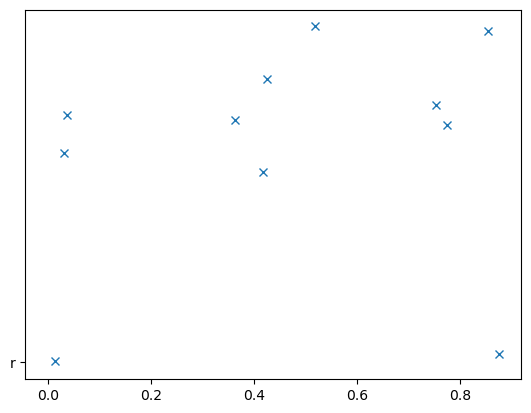

Cycle 1/20: Disagreement MSE = 0.09763488; Random MSE = 0.08449475


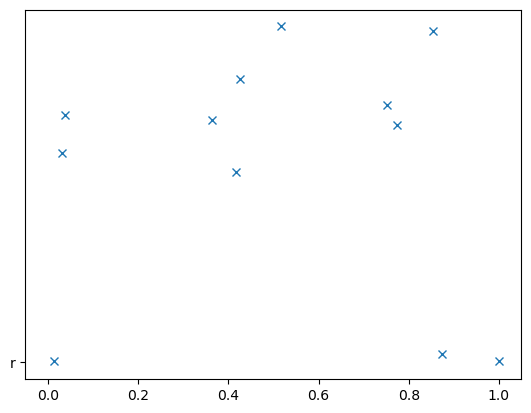

Cycle 2/20: Disagreement MSE = 0.07869281; Random MSE = 0.23338592


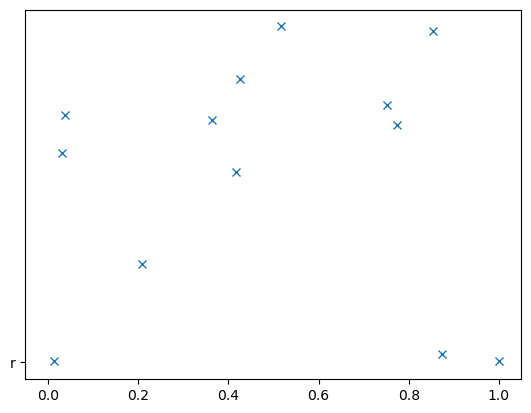

Cycle 3/20: Disagreement MSE = 0.13362051; Random MSE = 0.11094963


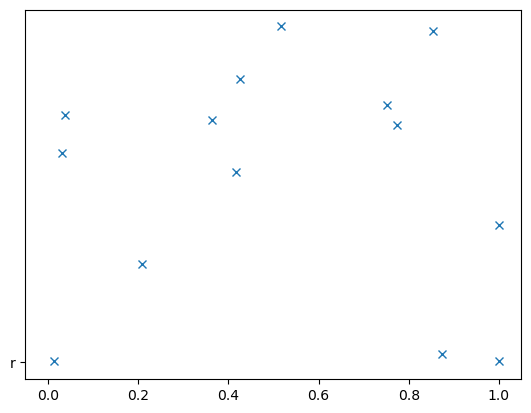

Cycle 4/20: Disagreement MSE = 0.12326154; Random MSE = 0.13272922


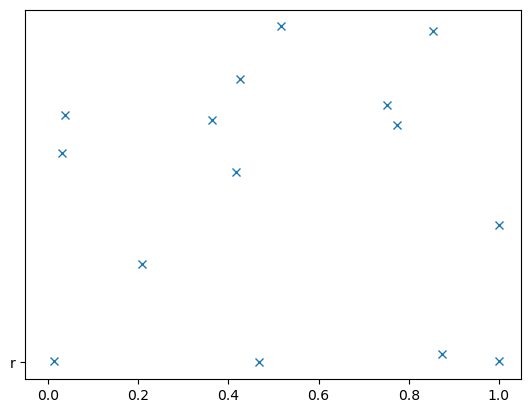

Cycle 5/20: Disagreement MSE = 0.14502754; Random MSE = 0.09768684


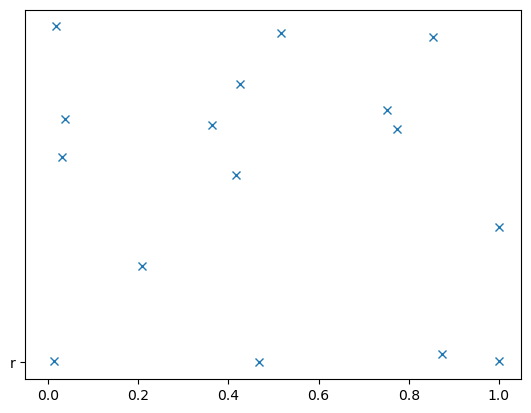

Cycle 6/20: Disagreement MSE = 0.09817599; Random MSE = 0.10919289


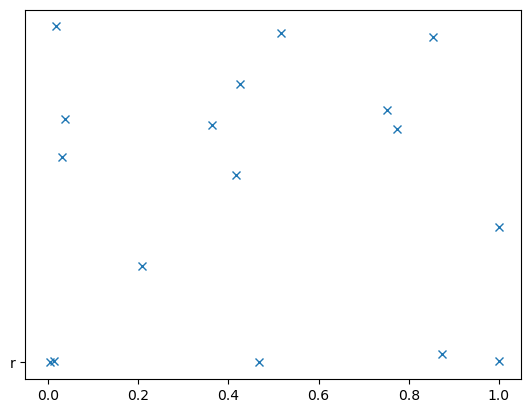

Cycle 7/20: Disagreement MSE = 0.13082823; Random MSE = 0.16774928


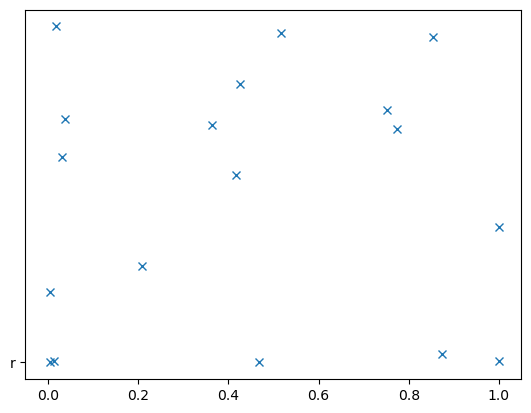

Cycle 8/20: Disagreement MSE = 0.09735061; Random MSE = 0.09828662


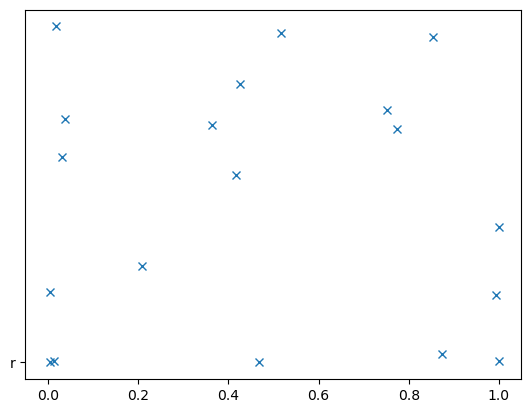

Cycle 9/20: Disagreement MSE = 0.07259217; Random MSE = 0.10664215


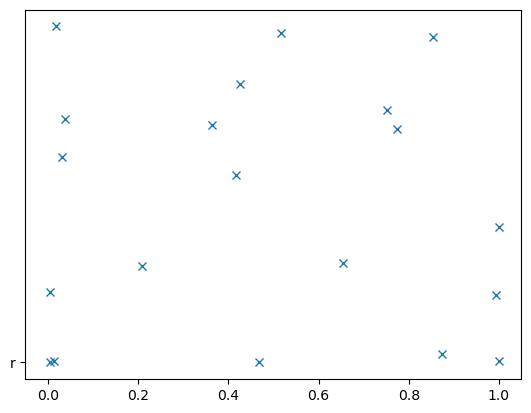

Cycle 10/20: Disagreement MSE = 0.07766985; Random MSE = 0.08207285


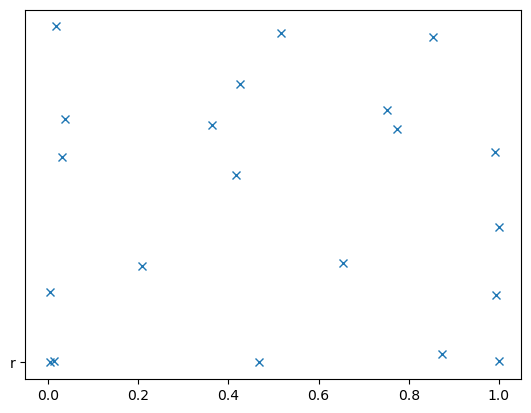

Cycle 11/20: Disagreement MSE = 0.08355692; Random MSE = 0.11330448


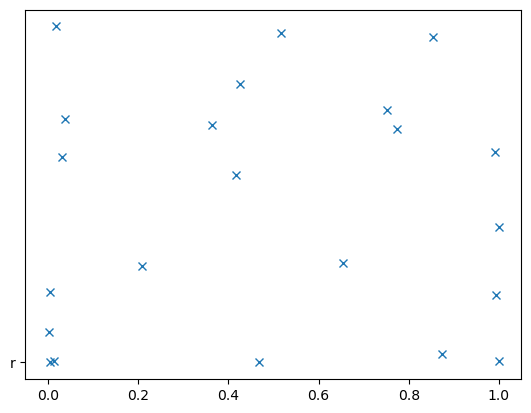

Cycle 12/20: Disagreement MSE = 0.06727458; Random MSE = 0.09503967


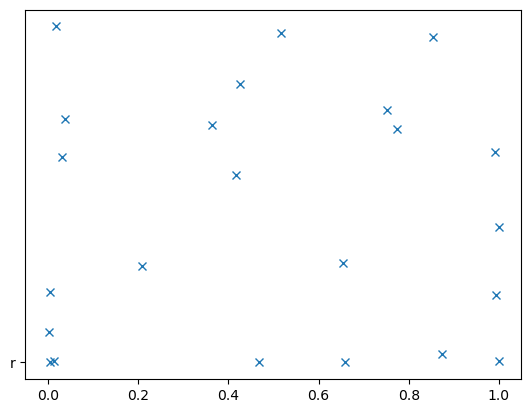

Cycle 13/20: Disagreement MSE = 0.06706939; Random MSE = 0.06671636


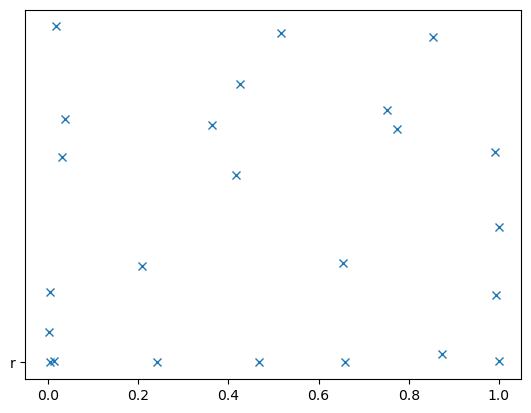

Cycle 14/20: Disagreement MSE = 0.0838827; Random MSE = 0.08592284


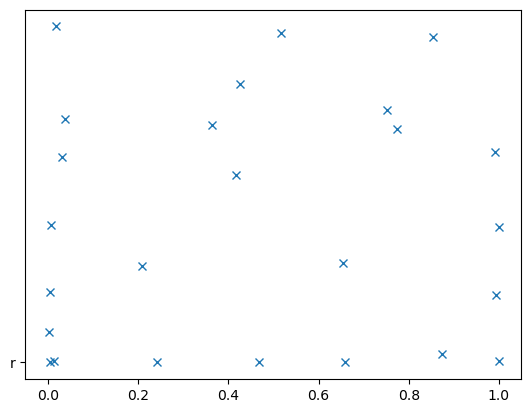

Cycle 15/20: Disagreement MSE = 0.05303483; Random MSE = 0.08544146


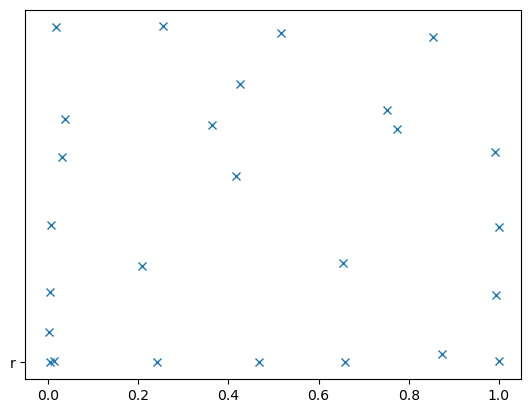

Cycle 16/20: Disagreement MSE = 0.08697718; Random MSE = 0.08612757


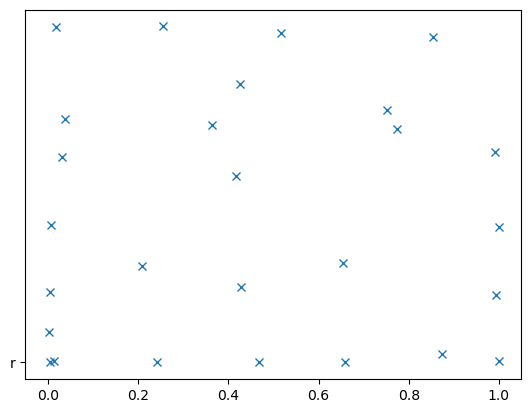

Cycle 17/20: Disagreement MSE = 0.09512338; Random MSE = 0.07100969


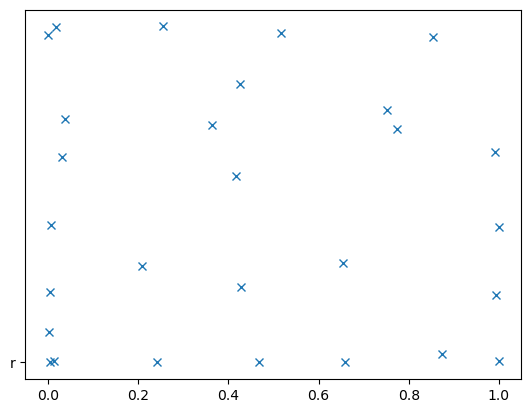

Cycle 18/20: Disagreement MSE = 0.07424168; Random MSE = 0.06682362


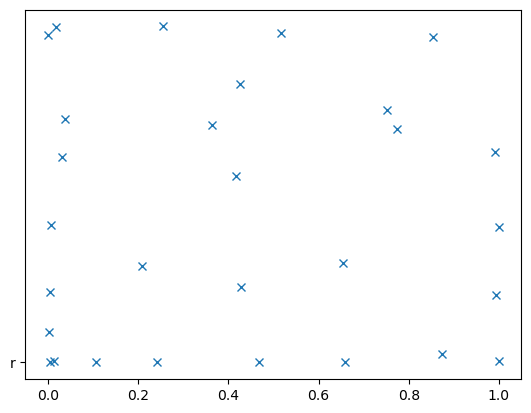

Cycle 19/20: Disagreement MSE = 0.06203768; Random MSE = 0.06627567


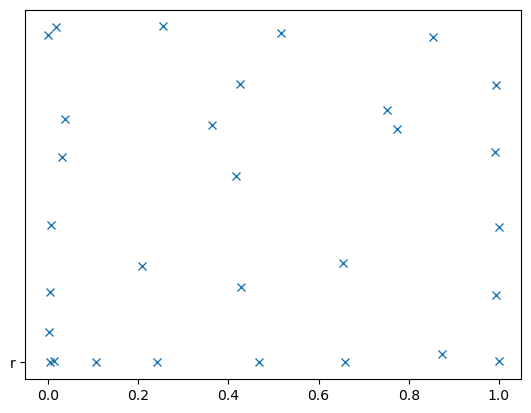

Cycle 20/20: Disagreement MSE = 0.0973433; Random MSE = 0.06801743


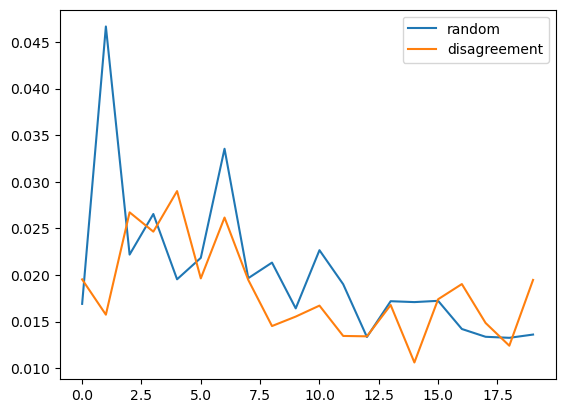

In [66]:
# ADD YOUR CODE HERE

n_cycles = 20

conditions_test = random_pool(experiment.variables, num_samples=10000)
test_data = experiment.run(conditions_test, noise_level_run=0).to_numpy()

from copy import deepcopy

conditions_disagreement = deepcopy(conditions_raw)
conditions_random = deepcopy(conditions_raw)

mse_disagreement_all = np.zeros(n_cycles)
mse_random_all = np.zeros(n_cycles)

for cycle in range(n_cycles):
    
    # get new conditions
    new_conditions_disagreement = disagreement_sampler(experiment, conditions_disagreement, theorist_disagreement, novelty_weight=0.05)
    conditions_disagreement = np.concatenate((conditions_disagreement, new_conditions_disagreement))
    new_conditions_random = random_pool(experiment.variables, num_samples=1)
    conditions_random = np.concatenate((conditions_random, new_conditions_random))
    
    # plot the sampled conditions
    plt.plot(conditions_disagreement[:, 0], conditions_disagreement[:, 1], 'x', 'r')
    plt.show()
    
    # collect data from experiment
    experiment_data_disagreement = experiment.run(conditions_disagreement).to_numpy()
    experiment_data_random = experiment.run(conditions_random).to_numpy()
    
    # fit your model
    for index_model, model in enumerate(theorist_disagreement):
        theorist_disagreement[index_model].fit(experiment_data_disagreement[:, :-1], experiment_data_disagreement[:, -1:])
        theorist_random[index_model].fit(experiment_data_random[:, :-1], experiment_data_random[:, -1:])
    
    # get test predictions
    mse_disagreement = 0
    mse_random = 0
    for index_model, model in enumerate(theorist_disagreement):
        pred_disagreement = theorist_disagreement[0].predict(test_data[:, :-1])
        mse_disagreement += np.mean((test_data[:, -1:]-pred_disagreement)**2)
        pred_random = theorist_random[0].predict(test_data[:, :-1])
        mse_random += np.mean((test_data[:, -1:]-pred_random)**2)
        
    mse_disagreement_all[cycle] += mse_disagreement/len(theorist_disagreement)
    mse_random_all[cycle] += mse_random/len(theorist_disagreement)
    
    # print results
    print(f"Cycle {cycle+1}/{n_cycles}: Disagreement MSE = {np.round(mse_disagreement, 8)}; Random MSE = {np.round(mse_random, 8)}")
    
plt.plot(mse_random_all, label='random')
plt.plot(mse_disagreement_all, label='disagreement')
plt.legend()
plt.show()

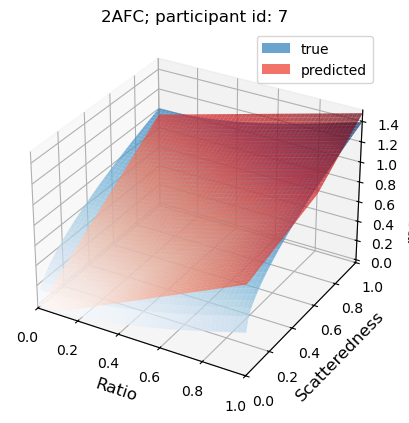

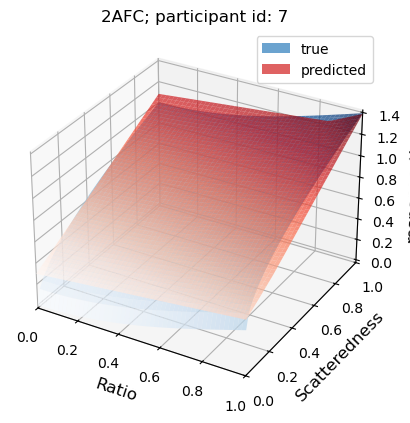

In [67]:
participant_id = 7

experiment.plotter(
    participant_id=participant_id,
    model=theorist_disagreement[0]
)

experiment.plotter(
    participant_id=participant_id,
    model=theorist_random[0]
)